<a href="https://colab.research.google.com/github/Mateusz0W/Inflation-Prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stare podejście

In [201]:
from process_data import combine_model_args,add_target_inflations,normalize_and_split_data_chronologically
from load_data import load_avarage_salary,load_building_price,load_inflation,load_unemployed
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

In [213]:
def plot_predicted_inflation(y,y_pred,year):
    plt.plot(np.arange(1,len(y)+1),y,label='prawdziwa wartość',marker='o')
    plt.plot(np.arange(1,len(y_pred)+1),y_pred,label='przewidywana wartość',marker='o',color='red')
    plt.xlabel('Miesiąc')
    plt.ylabel('Wartość')
    plt.title(f'Zmiana inflacji w {year}')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_metrics(X,y,y_pred,model):
    print('R^2 = ',model.score(X,y))
    print('MSE = ',mean_squared_error(y,y_pred))
    print('RMSE = ',np.sqrt(mean_squared_error(y, y_pred)))
    print('MAPE = ',mean_absolute_percentage_error(y, y_pred))

In [284]:
inflation_dict = load_inflation()
target_inflation_dict = {key: inflation_dict[key][1] for key in inflation_dict}
inflation_model_args_dict = {key: inflation_dict[key][0] for key in inflation_dict}
unemployed_dict = load_unemployed()
building_price_dict = load_building_price()
avarage_salary_dict = load_avarage_salary()

c:\Users\mateu\OneDrive\Pulpit\STUDIA\Semestr 6\Metody Inteligencji Obliczeniowej\Projekt\Inflation-Prediction\load_data.py:82: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['data'] = pd.to_datetime(data['Rok'].astype(str) + 'Q' + data['Kwartal'].astype(str))


In [285]:
start_year = 1995
end_year = 2024

combined_args = combine_model_args(inflation_model_args_dict, unemployed_dict, start_year, end_year)
combined_args = combine_model_args(combined_args, building_price_dict, start_year, end_year)
combined_args = combine_model_args(combined_args, avarage_salary_dict, start_year, end_year)
final_data = add_target_inflations(combined_args, target_inflation_dict)
X_train, X_test, y_train, y_test = normalize_and_split_data_chronologically(final_data)

In [304]:
model = MLPRegressor(solver='adam',hidden_layer_sizes=(10,10), max_iter = 6_000, tol = 0.001, activation = 'identity')
model.fit(X_train, y_train)
model.score(X_train,y_train)

0.8438609849656448

In [305]:
model.score(X_test,y_test)

0.8687581968061575

In [306]:
year = 2024
combined_args = combine_model_args(inflation_model_args_dict, unemployed_dict, year, year)
combined_args = combine_model_args(combined_args, building_price_dict, year, year)
combined_args = combine_model_args(combined_args, avarage_salary_dict, year, year)
final_data = add_target_inflations(combined_args, target_inflation_dict)
X, _, y, _ = normalize_and_split_data_chronologically(final_data,test_size=0.)
y_pred = model.predict(X)

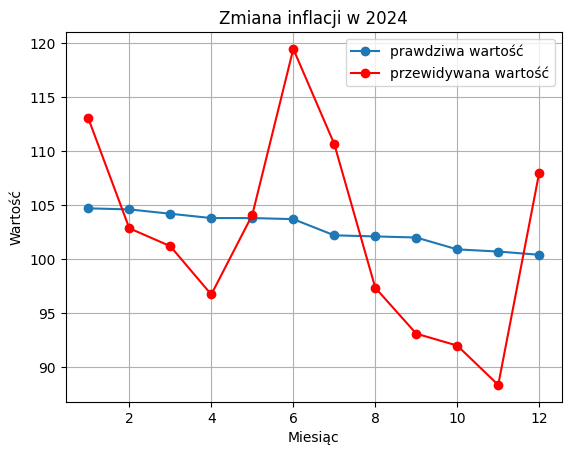

R^2 =  -30.374862437605
MSE =  70.25136733164554
RMSE =  8.38160887489064
MAPE =  0.07093771862627353


In [307]:
plot_predicted_inflation(y,y_pred,year)
print_metrics(X,y,y_pred,model)